In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr
import os

In [ ]:
# ===============================================================
# INDIVIDUAL AWARDS PREDICTION — DATA PREPARATION
# ===============================================================

# ===============================================================
# (1) Load Data
# ===============================================================
players = pd.read_csv("data/players.csv")
players_teams = pd.read_csv("data/players_teams.csv")
awards = pd.read_csv("data/awards_players.csv")
teams = pd.read_csv("data/teams.csv")
teams_post = pd.read_csv("data/teams_post.csv")

# output files
TRAIN_DATA_DIR = "data_models/award_train_data.csv"
TEST_DATA_DIR = "data_models/award_test_data.csv"

# ===============================================================
# (2) Filter to main awards only
# ===============================================================
main_awards = [
    'Most Valuable Player',
    'Defensive Player of the Year',
    'Rookie of the Year',
    'Most Improved Player',
    'WNBA Finals Most Valuable Player'
    # 'All Stars MVP' left out because we can't predict who will play in the target year's All Stars match
    # 'Coach of the Year' left out because coaches are not players, no player stats available
    # 'Kim Perrot Sportsmanship' left out because it's a subjective award based on sportsmanship, not performance stats
    # 'Sixth Woman of the Year' left out because it's an award for bench players; hard to predict from stats
    # 'WNBA All-Decade Team' left out because it's a retrospective team award, not annual individual prediction
    # 'WNBA All Decade Team Honorable Mention' left out for the same reason as above
]
awards_main = awards[awards['award'].isin(main_awards)]

target_year = 10

# ===============================================================
# (3) Create player performance features
# ===============================================================
player_stats = players_teams[players_teams['year'] < target_year].copy()
player_stats = player_stats[player_stats['GP'] >= 10]

# choosing players who've played over X games, per-game statistics
player_stats['ppg'] = player_stats['points'] / player_stats['GP']
player_stats['rpg'] = player_stats['rebounds'] / player_stats['GP']
player_stats['apg'] = player_stats['assists'] / player_stats['GP']
player_stats['spg'] = player_stats['steals'] / player_stats['GP']
player_stats['bpg'] = player_stats['blocks'] / player_stats['GP']
player_stats['mpg'] = player_stats['minutes'] / player_stats['GP']
player_stats['fg_pct'] = np.where(player_stats['fgAttempted'] > 0, 
                                   player_stats['fgMade'] / player_stats['fgAttempted'], 0)
player_stats['efficiency'] = (player_stats['points'] + player_stats['rebounds'] + 
                               player_stats['assists'] + player_stats['steals'] + 
                               player_stats['blocks'] - player_stats['turnovers']) / player_stats['GP']
player_stats['gs_pct'] = player_stats['GS'] / player_stats['GP']

# league averages by year
yearly_avg = player_stats.groupby('year').agg({
    'ppg': 'mean', 'rpg': 'mean', 'apg': 'mean', 'efficiency': 'mean'
}).reset_index()
yearly_avg.columns = ['year', 'league_ppg', 'league_rpg', 'league_apg', 'league_efficiency']
player_stats = player_stats.merge(yearly_avg, on='year', how='left')

player_stats['ppg_vs_avg'] = player_stats['ppg'] - player_stats['league_ppg']
player_stats['rpg_vs_avg'] = player_stats['rpg'] - player_stats['league_rpg']
player_stats['apg_vs_avg'] = player_stats['apg'] - player_stats['league_apg']
player_stats['efficiency_vs_avg'] = player_stats['efficiency'] - player_stats['league_efficiency']

# cumulative career stats (sum across all prior years for each player)
player_stats = player_stats.sort_values(['playerID', 'year'])
for col in ['ppg', 'rpg', 'apg', 'efficiency', 'mpg', 'spg', 'bpg']:
    player_stats[f'{col}_cumulative'] = player_stats.groupby('playerID')[col].cumsum()

# previous year stats
for col in ['ppg', 'rpg', 'apg', 'efficiency', 'mpg']:
    player_stats[f'{col}_prev'] = player_stats.groupby('playerID')[col].shift().fillna(0)

# rookie indicator
player_stats['is_rookie'] = player_stats.groupby('playerID').cumcount() == 0

# years of experience
player_stats['years_experience'] = player_stats.groupby('playerID').cumcount()

# add team context
teams_success = teams[teams['year'] <= 9][['year', 'tmID', 'won', 'lost', 'confID', 'playoff']].copy()
teams_success['win_pct'] = teams_success['won'] / (teams_success['won'] + teams_success['lost'])
teams_success['conf_rank'] = teams_success.groupby(['year', 'confID'])['win_pct'].rank(ascending=False)
teams_success['made_playoffs'] = teams_success['playoff'].notna().astype(int)

# championship indicator - identify team with most playoff wins each year
teams_post_years = teams_post[teams_post['year'] < target_year].copy()
playoff_wins = teams_post_years.groupby(['year', 'tmID'])['W'].sum().reset_index()
champion_idx = playoff_wins.groupby('year')['W'].idxmax()
champions = playoff_wins.loc[champion_idx][['year', 'tmID']].copy()
champions['won_championship'] = 1
teams_success = teams_success.merge(champions, on=['year', 'tmID'], how='left')
teams_success['won_championship'] = teams_success['won_championship'].fillna(0).astype(int)

player_stats = player_stats.merge(teams_success[['year', 'tmID', 'win_pct', 'conf_rank', 'made_playoffs', 'won_championship']], 
                                   on=['year', 'tmID'], how='left')

# playoff stats
playoff_stats = teams_post[teams_post['year'] <= 9].groupby(['year', 'tmID']).agg({'W': 'sum'}).reset_index()
playoff_stats.columns = ['year', 'tmID', 'playoff_wins']
player_stats = player_stats.merge(playoff_stats, on=['year', 'tmID'], how='left')
player_stats['playoff_wins'] = player_stats['playoff_wins'].fillna(0).astype(int)

# add award labels
for award in main_awards:
    col_name = f"won_{award.replace(' ', '_').lower()}"
    player_stats[col_name] = 0
    awards_filtered = awards_main[(awards_main['award'] == award) & (awards_main['year'] < target_year)]
    for _, row in awards_filtered.iterrows():
        mask = (player_stats['playerID'] == row['playerID']) & (player_stats['year'] == row['year'])
        player_stats.loc[mask, col_name] = 1

# award history features
player_stats['total_previous_awards'] = 0
player_stats['years_since_last_award'] = 99
for award in main_awards:
    col_name = f"won_{award.replace(' ', '_').lower()}"
    prev_col = f"prev_{award.replace(' ', '_').lower()}"
    player_stats[prev_col] = player_stats.groupby('playerID')[col_name].shift(1).fillna(0)
    player_stats['total_previous_awards'] += player_stats.groupby('playerID')[col_name].cumsum().shift(1).fillna(0)

# calculate actual years since last award
for player_id in player_stats['playerID'].unique():
    player_data = player_stats[player_stats['playerID'] == player_id].copy()
    award_years = []
    for award in main_awards:
        col_name = f"won_{award.replace(' ', '_').lower()}"
        winner_years = player_data[player_data[col_name] == 1]['year'].tolist()
        award_years.extend(winner_years)
    
    if award_years:  # player has won awards
        last_award_year = max(award_years)
        # calculate years since last award for each row
        player_stats.loc[player_stats['playerID'] == player_id, 'years_since_last_award'] = player_stats.loc[player_stats['playerID'] == player_id, 'year'] - last_award_year
    # if no awards, keep as 99

# save training data
os.makedirs("data_models", exist_ok=True)
player_stats.to_csv(TRAIN_DATA_DIR, index=False)

print(f"// Training data saved: {player_stats.shape}")

# ===============================================================
# (4) Prepare test data (same features)
# ===============================================================
player_stats_test = players_teams[players_teams['year'] == target_year].copy()
player_stats_test = player_stats_test[player_stats_test['GP'] >= target_year]

# choosing players who've played over X games, per-game statistics
player_stats_test['ppg'] = player_stats_test['points'] / player_stats_test['GP']
player_stats_test['rpg'] = player_stats_test['rebounds'] / player_stats_test['GP']
player_stats_test['apg'] = player_stats_test['assists'] / player_stats_test['GP']
player_stats_test['spg'] = player_stats_test['steals'] / player_stats_test['GP']
player_stats_test['bpg'] = player_stats_test['blocks'] / player_stats_test['GP']
player_stats_test['mpg'] = player_stats_test['minutes'] / player_stats_test['GP']
player_stats_test['fg_pct'] = np.where(player_stats_test['fgAttempted'] > 0, 
                                      player_stats_test['fgMade'] / player_stats_test['fgAttempted'], 0)
player_stats_test['efficiency'] = (player_stats_test['points'] + player_stats_test['rebounds'] + 
                                  player_stats_test['assists'] + player_stats_test['steals'] + 
                                  player_stats_test['blocks'] - player_stats_test['turnovers']) / player_stats_test['GP']
player_stats_test['gs_pct'] = player_stats_test['GS'] / player_stats_test['GP']

# league averages by year
testyear_avg = player_stats_test.agg({'ppg': 'mean', 'rpg': 'mean', 'apg': 'mean', 'efficiency': 'mean'})

player_stats_test['ppg_vs_avg'] = player_stats_test['ppg'] - testyear_avg['ppg']
player_stats_test['rpg_vs_avg'] = player_stats_test['rpg'] - testyear_avg['rpg']
player_stats_test['apg_vs_avg'] = player_stats_test['apg'] - testyear_avg['apg']
player_stats_test['efficiency_vs_avg'] = player_stats_test['efficiency'] - testyear_avg['efficiency']

# historical cumulative career stats
for player_id in player_stats_test['playerID'].unique():
    player_history = player_stats[player_stats['playerID'] == player_id]
    if len(player_history) > 0:

        latest = player_history.iloc[-1]
        for col in ['ppg', 'rpg', 'apg', 'efficiency', 'mpg', 'spg', 'bpg']:

            player_stats_test.loc[player_stats_test['playerID'] == player_id, f'{col}_cumulative'] = latest[f'{col}_cumulative']

            player_stats_test.loc[player_stats_test['playerID'] == player_id, f'{col}_prev'] = latest[col]
        player_stats_test.loc[player_stats_test['playerID'] == player_id, 'years_experience'] = latest['years_experience'] + 1
        player_stats_test.loc[player_stats_test['playerID'] == player_id, 'total_previous_awards'] = latest['total_previous_awards']
        for award in main_awards:
            prev_col = f"prev_{award.replace(' ', '_').lower()}"
            col_name = f"won_{award.replace(' ', '_').lower()}"
            player_stats_test.loc[player_stats_test['playerID'] == player_id, prev_col] = latest[col_name]
    else:

        for col in ['ppg', 'rpg', 'apg', 'efficiency', 'mpg', 'spg', 'bpg']:
            player_stats_test.loc[player_stats_test['playerID'] == player_id, f'{col}_cumulative'] = 0
            player_stats_test.loc[player_stats_test['playerID'] == player_id, f'{col}_prev'] = 0
        player_stats_test.loc[player_stats_test['playerID'] == player_id, 'years_experience'] = 0
        player_stats_test.loc[player_stats_test['playerID'] == player_id, 'total_previous_awards'] = 0

# ensure columns exist, handle missing values
for col in ['ppg', 'rpg', 'apg', 'efficiency', 'mpg', 'spg', 'bpg']:
    if f'{col}_cumulative' not in player_stats_test.columns:
        player_stats_test[f'{col}_cumulative'] = player_stats_test[col] # ppg cumulative = ppg if missing
    if f'{col}_prev' not in player_stats_test.columns:
        player_stats_test[f'{col}_prev'] = 0
    player_stats_test[f'{col}_cumulative'] = player_stats_test[f'{col}_cumulative'].fillna(player_stats_test[col])  # ppg cumulative = ppg if missing
    player_stats_test[f'{col}_prev'] = player_stats_test[f'{col}_prev'].fillna(0)
if 'years_experience' not in player_stats_test.columns:
    player_stats_test['years_experience'] = 0
if 'total_previous_awards' not in player_stats_test.columns:
    player_stats_test['total_previous_awards'] = 0
player_stats_test['years_experience'] = player_stats_test['years_experience'].fillna(0)
player_stats_test['total_previous_awards'] = player_stats_test['total_previous_awards'].fillna(0)
player_stats_test['is_rookie'] = player_stats_test['years_experience'] == 0
player_stats_test['years_since_last_award'] = 99 # default. to be treated as "never won"

# add team context
teams_test = teams[teams['year'] == target_year][['year', 'tmID', 'won', 'lost', 'confID', 'playoff']].copy()
teams_test['win_pct'] = teams_test['won'] / (teams_test['won'] + teams_test['lost'])
teams_test['conf_rank'] = teams_test.groupby(['year', 'confID'])['win_pct'].rank(ascending=False)
teams_test['made_playoffs'] = teams_test['playoff'].notna().astype(int)
champs_test = teams_test[teams_test['playoff'] == 'Finals']['tmID'].values
teams_test['won_championship'] = teams_test['tmID'].isin(champs_test).astype(int)
player_stats_test = player_stats_test.merge(teams_test[['year', 'tmID', 'win_pct', 'conf_rank', 'made_playoffs', 'won_championship']], 
                                         on=['year', 'tmID'], how='left')

# playoff stats
playoff_stats_test = teams_post[teams_post['year'] == target_year].groupby(['year', 'tmID']).agg({'W': 'sum'}).reset_index()
playoff_stats_test.columns = ['year', 'tmID', 'playoff_wins']
player_stats_test = player_stats_test.merge(playoff_stats_test, on=['year', 'tmID'], how='left')
player_stats_test['playoff_wins'] = player_stats_test['playoff_wins'].fillna(0).astype(int)

# add award labels - not used at prediction, just for evaluation
for award in main_awards:
    prev_col = f"prev_{award.replace(' ', '_').lower()}"
    if prev_col not in player_stats_test.columns:
        player_stats_test[prev_col] = 0
    player_stats_test[prev_col] = player_stats_test[prev_col].fillna(0)

for award in main_awards:
    col_name = f"won_{award.replace(' ', '_').lower()}"
    player_stats_test[col_name] = 0
    awards_test = awards_main[(awards_main['award'] == award) & (awards_main['year'] == target_year)]
    for _, row in awards_test.iterrows():
        mask = (player_stats_test['playerID'] == row['playerID'])
        player_stats_test.loc[mask, col_name] = 1

player_stats_test.to_csv(TEST_DATA_DIR, index=False)
print(f"\n// Test data saved: {player_stats_test.shape}")


// Training data saved: (1458, 91)

// Test data saved: (145, 89)

// Test data saved: (145, 89)


# Individual Awards Prediction Approach

## Overview
This notebook predicts WNBA individual awards using machine learning models trained on historical player and team statistics. We focus on five major awards: MVP, Defensive Player of the Year (DPOY), Rookie of the Year (ROY), Most Improved Player (MIP), and Finals MVP.

## Prediction Strategy
- **Labels**: Binary classification (1 if player won the award in that year, 0 otherwise). Since awards are highly imbalanced (only 1 winner per year), we predict probabilities and rank players to identify top candidates.
- **Class Imbalance Handling**: Use `class_weight='balanced'` in Random Forest to give more weight to the minority class (award winners).
- **Validation Strategy**: Time-series split - train on data from years 1-9, test on year 10 (future year). This simulates real-world prediction where we use past data to predict future awards.
- **Models**: Random Forest with 200 trees, max depth 10, random state 42 for reproducibility.
- **Evaluation**: Mean Reciprocal Rank (MRR) for ranking quality, plus standard classification metrics.

## Award-Specific Features
Each award uses tailored features reflecting its criteria:
- **MVP**: Scoring, playmaking, efficiency, team success
- **DPOY**: Defensive stats (steals, blocks, rebounds), defensive efficiency
- **ROY**: Basic stats with rookie indicator, limited experience
- **MIP**: Year-over-year improvement metrics
- **Finals MVP**: Playoff performance, championship experience

## Interpretability
For each award, we provide feature importance plots and analyze top predicted players with explanations based on their key stats.

Training: (1458, 91) | Test: (145, 89)

MVP winners in training: 9
MVP winners in test: 1
Class balance: 9/1458 = 0.62%
Total features: 30 (including 10 historical features)

// MVP Ranking Evaluation for year 10:
Actual winner rank: 1 out of 145
Actual winner probability: 0.230
Top-1 prediction: ✓ CORRECT
Top-3 prediction: ✓ CORRECT
Top-5 prediction: ✓ CORRECT
Top-10 prediction: ✓ CORRECT
Mean Reciprocal Rank: 1.0000
Spearman Rank Correlation: 0.4182 (p=0.0000)

// Top 10 MVP candidates:
       playerID tmID        ppg   win_pct  made_playoffs  mvp_proba  mvp_rank  \
120  tauradi01w  PHO  20.354839  0.676471              1   0.229559       1.0   
52   jacksla01w  SEA  19.192308  0.588235              1   0.054855       2.0   
101  pondeca01w  PHO  19.058824  0.676471              1   0.049983       3.0   
141  youngso01w  SAS  18.181818  0.441176              1   0.019969       4.0   
38   hammobe01w  SAS  19.483871  0.441176              1   0.014939       5.0   
97   parkeca01w  LAS

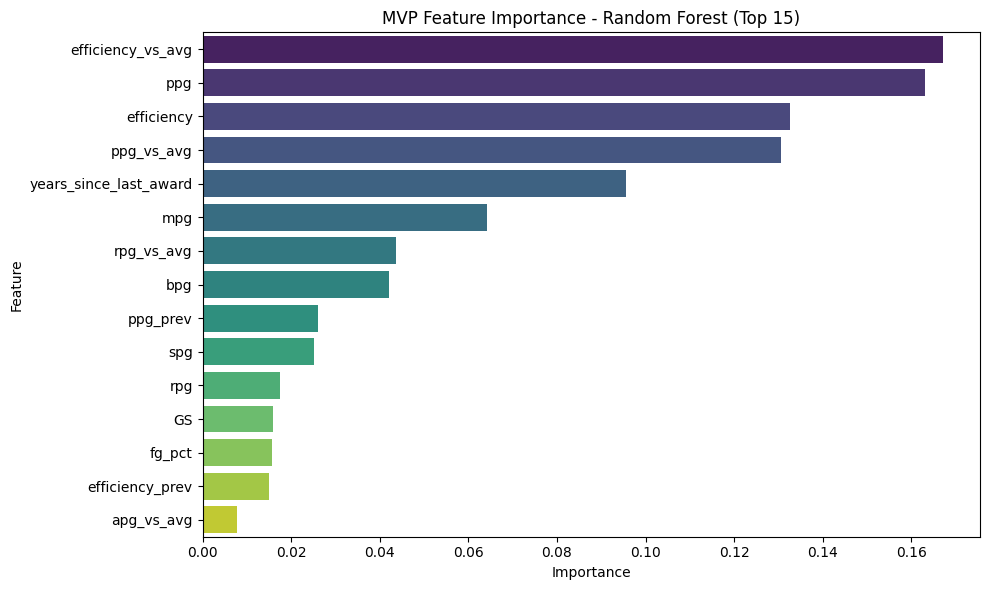


// Top 10 Most Important Features:
                   Feature  Importance
17       efficiency_vs_avg    0.167126
0                      ppg    0.163109
7               efficiency    0.132590
14              ppg_vs_avg    0.130474
27  years_since_last_award    0.095684
5                      mpg    0.064186
15              rpg_vs_avg    0.043580
4                      bpg    0.041984
23                ppg_prev    0.026049
3                      spg    0.025202

// New Historical Features Impact:
                      Feature  Importance
23                   ppg_prev    0.026049
24            efficiency_prev    0.014957
18             ppg_cumulative    0.005187
25                   mpg_prev    0.004469
19             rpg_cumulative    0.004065
26      total_previous_awards    0.001766
20             apg_cumulative    0.001422
22             mpg_cumulative    0.001056
21      efficiency_cumulative    0.000807
28  prev_most_valuable_player    0.000102


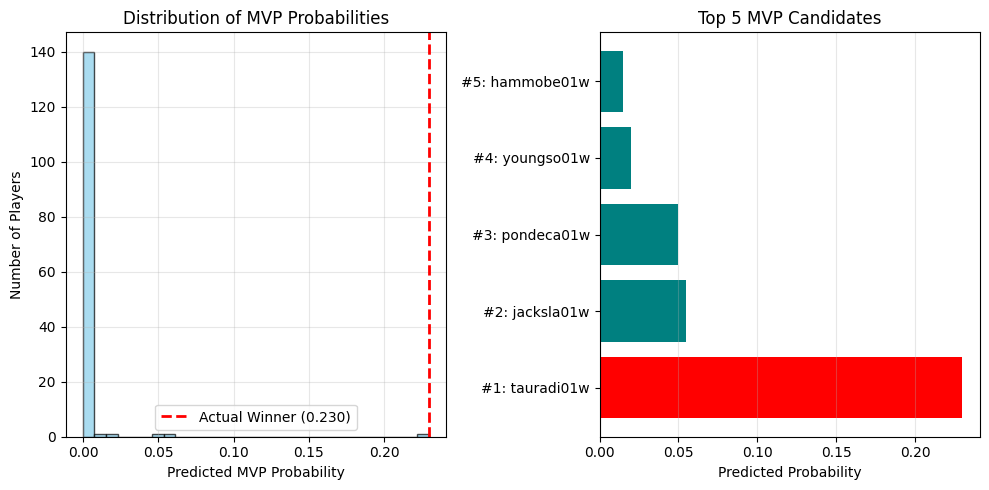

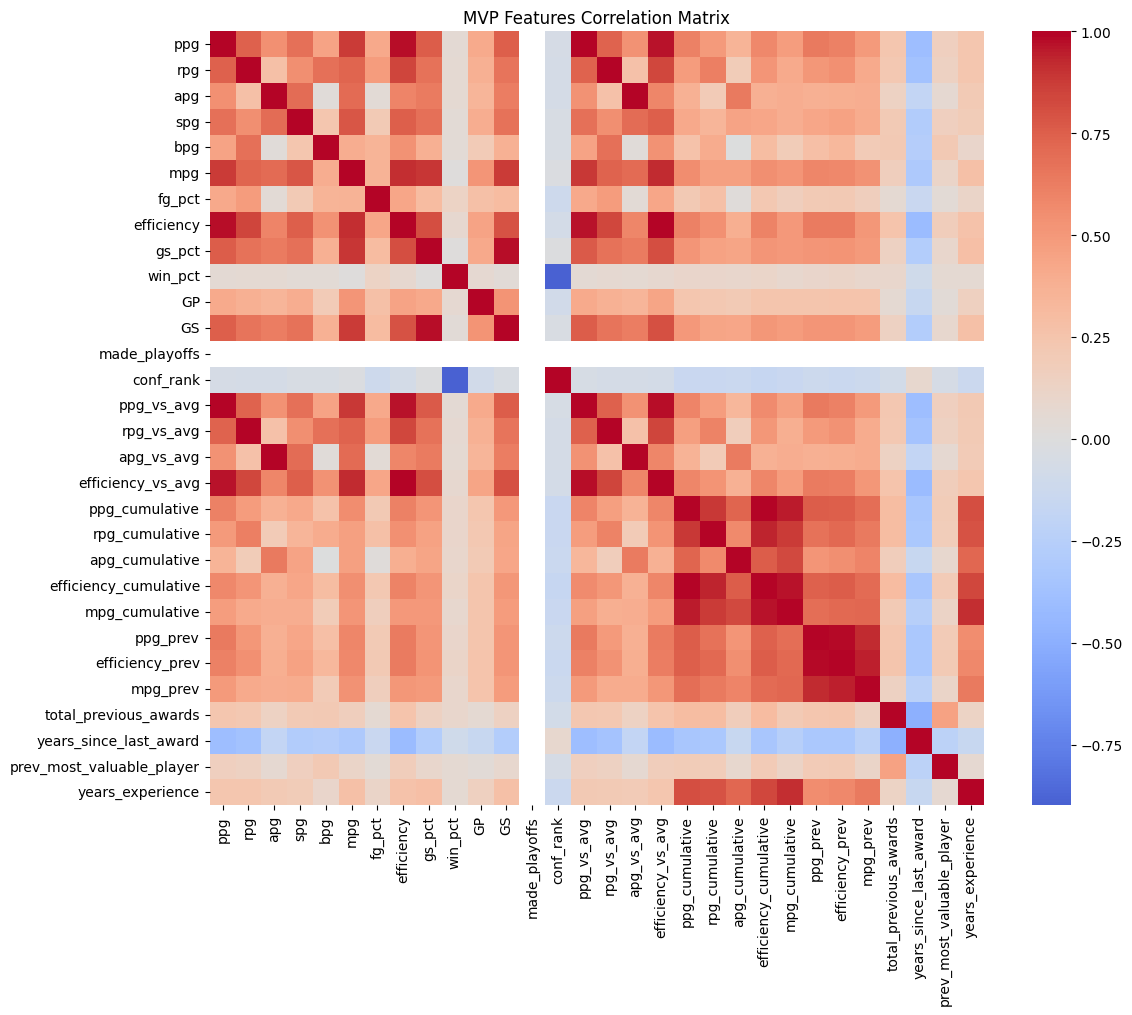


// Results saved to: data_models/predictions_mvp.csv


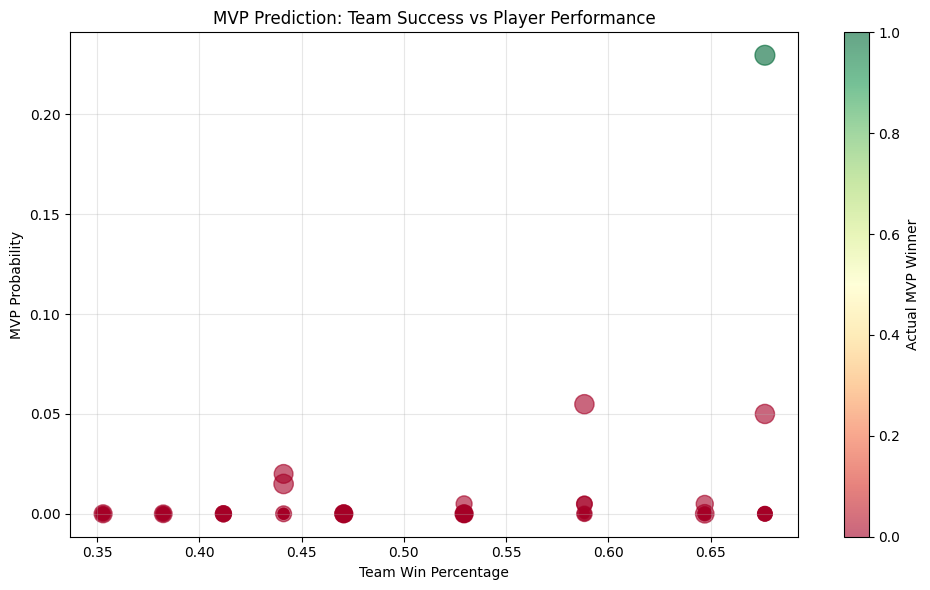

In [ ]:
# ===============================================================
# MVP PREDICTION — MODEL & EVALUATION
# ===============================================================

target = 'won_most_valuable_player'

# ===============================================================
# (1) Load prepared dataset
# ===============================================================
train_data = pd.read_csv(TRAIN_DATA_DIR)
test_data = pd.read_csv(TEST_DATA_DIR)

print(f"Training: {train_data.shape} | Test: {test_data.shape}")

# ===============================================================
# (2) Define features and target for MVP
# ===============================================================
features = [
    # current year performance
    'ppg', 'rpg', 'apg', 'spg', 'bpg', 'mpg',
    'fg_pct', 'efficiency', 'gs_pct', 'win_pct', 'GP', 'GS',
    'made_playoffs', 'conf_rank', 
    
    # comparative to league average
    'ppg_vs_avg', 'rpg_vs_avg', 'apg_vs_avg', 'efficiency_vs_avg',
    
    # cumulative features
    'ppg_cumulative', 'rpg_cumulative', 'apg_cumulative', 
    'efficiency_cumulative', 'mpg_cumulative',
    
    # previous year performance
    'ppg_prev', 'efficiency_prev', 'mpg_prev',
    
    # award history
    'total_previous_awards', 'years_since_last_award',
    'prev_most_valuable_player',
    
    # experience
    'years_experience'
]

x_train = train_data[features]
y_train = train_data[target]
x_test = test_data[features]
y_test = test_data[target]

print(f"\nMVP winners in training: {y_train.sum()}")
print(f"MVP winners in test: {y_test.sum()}")
print(f"Class balance: {y_train.sum()}/{len(y_train)} = {y_train.sum()/len(y_train)*100:.2f}%")
print(f"Total features: {len(features)} (including {len([f for f in features if 'cumulative' in f or 'prev' in f or 'previous' in f])} historical features)")

# ===============================================================
# (3) Train Random Forest model
# ===============================================================
model_mvp = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
model_mvp.fit(x_train, y_train)

# ===============================================================
# (4) Predict probabilities and rank
# ===============================================================
y_pred_proba = model_mvp.predict_proba(x_test)[:, 1]
test_data = test_data.copy()
test_data['mvp_proba'] = y_pred_proba
test_data['mvp_rank'] = test_data['mvp_proba'].rank(ascending=False, method='first')
test_data = test_data.sort_values('mvp_proba', ascending=False)

# ===============================================================
# (5) Evaluation
# ===============================================================
winner_rank = None
winner_proba = None
actual_winner_id = None

actual_winner_id_array = test_data[test_data[target] == 1]['playerID'].values
if len(actual_winner_id_array) > 0:
    actual_winner_id = actual_winner_id_array[0]
    winner_rank = test_data[test_data['playerID'] == actual_winner_id]['mvp_rank'].values[0]
    winner_proba = test_data[test_data['playerID'] == actual_winner_id]['mvp_proba'].values[0]
    
    print(f"\n// MVP Ranking Evaluation for year 10:")
    print(f"Actual winner rank: {int(winner_rank)} out of {len(test_data)}")
    print(f"Actual winner probability: {winner_proba:.3f}")
    print(f"Top-1 prediction: {'✓ CORRECT' if winner_rank == 1 else '✗ INCORRECT'}")
    print(f"Top-3 prediction: {'✓ CORRECT' if winner_rank <= 3 else '✗ INCORRECT'}")
    print(f"Top-5 prediction: {'✓ CORRECT' if winner_rank <= 5 else '✗ INCORRECT'}")
    print(f"Top-10 prediction: {'✓ CORRECT' if winner_rank <= 10 else '✗ INCORRECT'}")
    
    # mean reciprocal rank
    mrr = 1.0 / winner_rank
    print(f"Mean Reciprocal Rank: {mrr:.4f}")
    
    # spearman correlation between predicted probabilities and actual winner
    # create binary actual ranking (1 for winner, 0 for others)
    test_data['actual_winner'] = (test_data['playerID'] == actual_winner_id).astype(int)
    from scipy.stats import spearmanr
    spearman_corr, spearman_p = spearmanr(-test_data['mvp_proba'], test_data['mvp_rank'])
    print(f"Spearman Rank Correlation: {spearman_corr:.4f} (p={spearman_p:.4f})")
else:
    print("\nNo MVP winner in test set")

# ===============================================================
# (6) Top MVP candidates
# ===============================================================
print("\n// Top 10 MVP candidates:")
top_mvp = test_data[[
    'playerID', 'tmID', 'ppg', 'rpg', 'apg', 'efficiency',
    'win_pct', 'made_playoffs', 'conf_rank',
    'mvp_proba', 'mvp_rank', 'won_most_valuable_player'
]].sort_values('mvp_proba', ascending=False).head(10)
print(top_mvp[['playerID', 'tmID', 'ppg', 'win_pct', 'made_playoffs', 'mvp_proba', 'mvp_rank', 'won_most_valuable_player']])

# ===============================================================
# (7) MVP Interpretability Insights
# ===============================================================
print("Top 3 MVP Candidates and Key Factors:")
top_3_mvp = test_data.nsmallest(3, 'mvp_rank')
for i, (_, row) in enumerate(top_3_mvp.iterrows(), 1):
    print(f"\n{i}. {row['playerID']} (Rank #{int(row['mvp_rank'])}, Prob: {row['mvp_proba']:.3f})")
    print(f"   - Scoring: {row['ppg']:.1f} PPG, {row['efficiency']:.1f} EFF (vs avg: {row['ppg_vs_avg']:.1f})")
    print(f"   - Playmaking: {row['apg']:.1f} APG, {row['rpg']:.1f} RPG")
    print(f"   - Team Success: {row['win_pct']:.1f} win %, {row['playoff_wins']} playoff wins")
    print(f"   - Experience: {row['years_experience']} years, {row['total_previous_awards']} prior awards")
    if row['playerID'] == actual_winner_id:
        print("   *** ACTUAL WINNER ***")

# ===============================================================
# (8) Feature Importance
# ===============================================================
importance = pd.DataFrame({
    'Feature': features,
    'Importance': model_mvp.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
top_features = importance.head(15)
import seaborn as sns
sns.barplot(data=top_features, x='Importance', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title('MVP Feature Importance - Random Forest (Top 15)')
plt.tight_layout()
plt.show()

print("\n// Top 10 Most Important Features:")
print(importance.head(10))

# check impact of new features
if len([f for f in features if 'cumulative' in f or 'prev' in f or 'previous' in f]) > 0:
    print(f"\n// New Historical Features Impact:")
    new_feature_importance = importance[importance['Feature'].str.contains('cumulative|prev|previous')]
    print(new_feature_importance)

# ===============================================================
# (9) Visualization
# ===============================================================
plt.figure(figsize=(10, 5))

# left plot: distribution of predicted probabilities
plt.subplot(1, 2, 1)
plt.hist(test_data['mvp_proba'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
if winner_proba is not None:
    plt.axvline(winner_proba, color='red', linestyle='--', linewidth=2, label=f'Actual Winner ({winner_proba:.3f})')
plt.xlabel('Predicted MVP Probability')
plt.ylabel('Number of Players')
plt.title('Distribution of MVP Probabilities')
plt.legend()
plt.grid(alpha=0.3)

# right plot: top candidates probability comparison
plt.subplot(1, 2, 2)
top_5 = test_data.nsmallest(5, 'mvp_rank')
colors = ['red' if pid == actual_winner_id else 'teal' for pid in top_5['playerID']]
plt.barh(range(len(top_5)), top_5['mvp_proba'], color=colors)
plt.yticks(range(len(top_5)), [f"#{int(r)}: {pid}" for r, pid in zip(top_5['mvp_rank'], top_5['playerID'])])
plt.xlabel('Predicted Probability')
plt.title('Top 5 MVP Candidates')
plt.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# correlation matrix for MVP features
plt.figure(figsize=(12, 10))
corr_matrix = train_data[features].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, square=True)
plt.title('MVP Features Correlation Matrix')
plt.tight_layout()
plt.show()

# ===============================================================
# (10) Save predictions
# ===============================================================
test_data.to_csv("data_models/predictions_mvp.csv", index=False)
print("\n// Results saved to: data_models/predictions_mvp.csv")

# ===============================================================
# (11) Analysis: Team Success vs MVP Probability
# ===============================================================
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    test_data['win_pct'], 
    test_data['mvp_proba'],
    c=test_data['won_most_valuable_player'],
    s=test_data['ppg']*10,
    alpha=0.6,
    cmap='RdYlGn'
)
plt.xlabel('Team Win Percentage')
plt.ylabel('MVP Probability')
plt.title('MVP Prediction: Team Success vs Player Performance')
plt.colorbar(scatter, label='Actual MVP Winner')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


DPOY winners in training: 9
DPOY winners in test: 1
Class balance: 9/1458 = 0.62%

// DPOY Ranking Evaluation for year 10:
Actual winner rank: 1 out of 145
Actual winner probability: 0.070
Top-1 prediction: ✓ CORRECT
Top-3 prediction: ✓ CORRECT
Top-5 prediction: ✓ CORRECT
Mean Reciprocal Rank: 1.0000

// Top 10 DPOY candidates:
       playerID tmID       spg       bpg   win_pct  dpoy_proba  dpoy_rank  \
19   catchta01w  IND  2.911765  0.529412  0.647059    0.070000        1.0   
1    anosini01w  MIN  2.700000  0.933333  0.411765    0.060000        2.0   
120  tauradi01w  PHO  1.161290  1.387097  0.676471    0.054892        3.0   
52   jacksla01w  SEA  1.461538  1.730769  0.588235    0.044939        4.0   
39   hardili01w  WAS  1.264706  0.382353  0.470588    0.010000        5.0   
10   bonnede01w  PHO  0.676471  0.735294  0.676471    0.005000        6.0   
49   hornbal01w  DET  1.312500  0.281250  0.529412    0.005000       10.0   
50   houstch01w  MIN  1.264706  0.617647  0.411765    

/tmp/ipykernel_19343/2726699436.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x='Importance', y='Feature', palette='coolwarm')


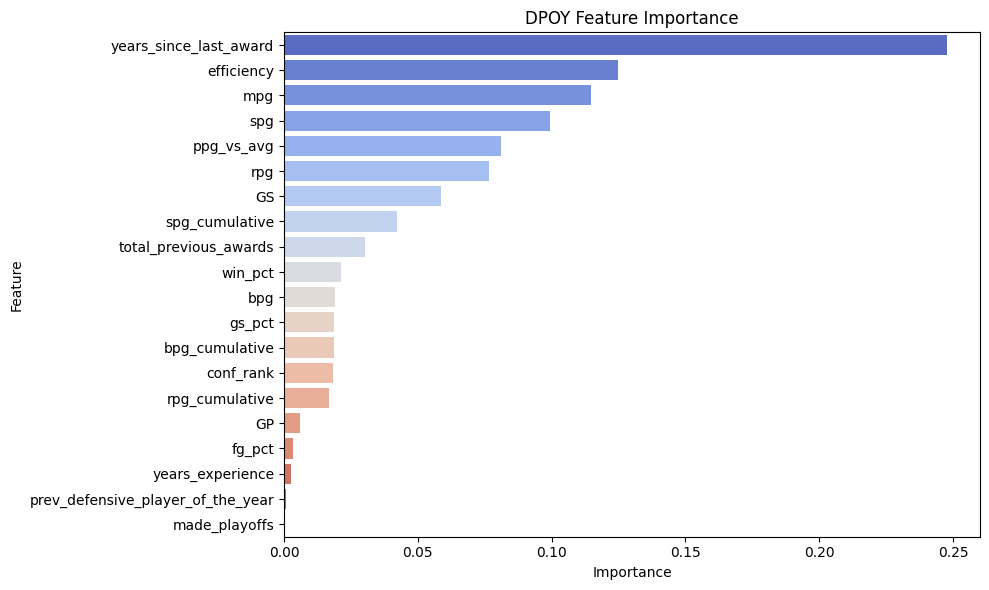


// Top 10 Most Important Features:
                   Feature  Importance
17  years_since_last_award    0.247660
4               efficiency    0.124713
3                      mpg    0.114540
0                      spg    0.099459
15              ppg_vs_avg    0.080962
2                      rpg    0.076590
8                       GS    0.058552
11          spg_cumulative    0.042155
16   total_previous_awards    0.030228
6                  win_pct    0.021411


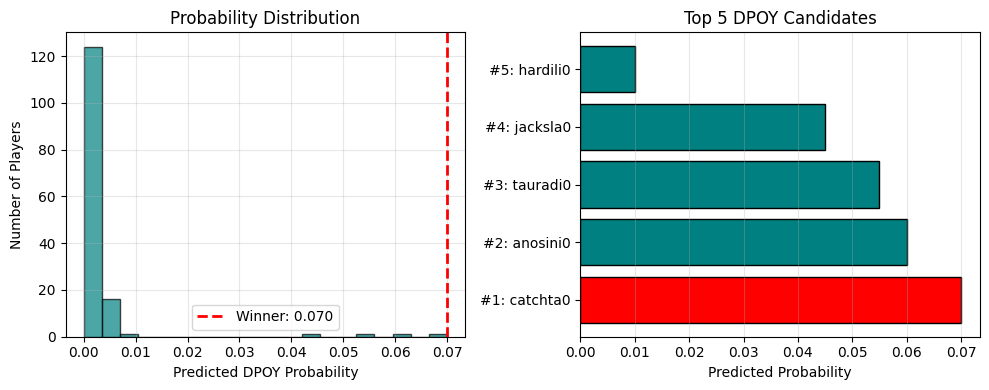

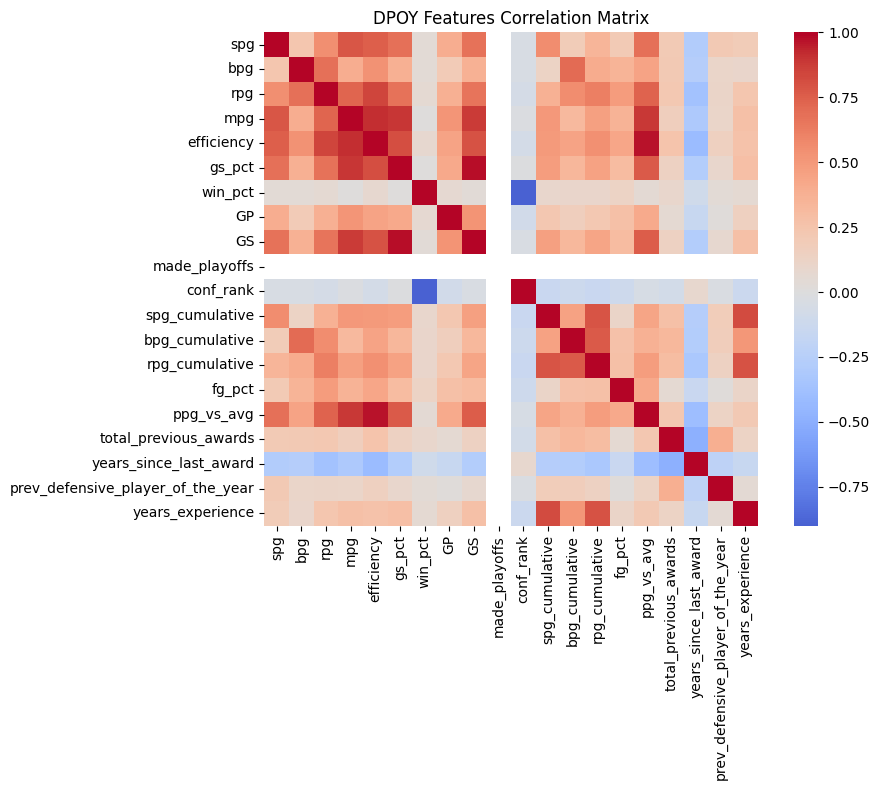


// Results saved to: data_models/predictions_dpoy.csv


In [ ]:
# ===============================================================
# DEFENSIVE PLAYER OF THE YEAR — MODEL & EVALUATION
# ===============================================================

target = 'won_defensive_player_of_the_year'

# ===============================================================
# (1) Load data
# ===============================================================
train_data = pd.read_csv(TRAIN_DATA_DIR)
test_data = pd.read_csv(TEST_DATA_DIR)

# ===============================================================
# (2) Features focused on defense
# ===============================================================
features_dpoy = [
    # defensive stats
    'spg', 'bpg', 'rpg', 'mpg', 'efficiency',
    'gs_pct', 'win_pct', 'GP', 'GS',
    'made_playoffs', 'conf_rank',
    
    # cumulative defensive prowess
    'spg_cumulative', 'bpg_cumulative', 'rpg_cumulative',
    
    # defensive efficiency context
    'fg_pct',
    'ppg_vs_avg',
    
    # award history
    'total_previous_awards', 'years_since_last_award',
    'prev_defensive_player_of_the_year',
    
    # experience
    'years_experience'
]

x_train = train_data[features_dpoy]
y_train = train_data[target]
x_test = test_data[features_dpoy]
y_test = test_data[target]

print(f"DPOY winners in training: {y_train.sum()}")
print(f"DPOY winners in test: {y_test.sum()}")
print(f"Class balance: {y_train.sum()}/{len(y_train)} = {y_train.sum()/len(y_train)*100:.2f}%")

# ===============================================================
# (3) Train model
# ===============================================================
model_dpoy = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)
model_dpoy.fit(x_train, y_train)

# ===============================================================
# (4) Predictions
# ===============================================================
test_data = test_data.copy()
test_data.loc[:, 'dpoy_proba'] = model_dpoy.predict_proba(x_test)[:, 1]
test_data.loc[:, 'dpoy_rank'] = test_data['dpoy_proba'].rank(ascending=False, method='first')

# ===============================================================
# (5) Evaluation
# ===============================================================
actual_winner_id_array = test_data[test_data[target] == 1]['playerID'].values
if len(actual_winner_id_array) > 0:
    actual_winner_id = actual_winner_id_array[0]
    winner_rank = test_data[test_data['playerID'] == actual_winner_id]['dpoy_rank'].values[0]
    winner_proba = test_data[test_data['playerID'] == actual_winner_id]['dpoy_proba'].values[0]
    
    print(f"\n// DPOY Ranking Evaluation for year {target_year}:")
    print(f"Actual winner rank: {int(winner_rank)} out of {len(test_data)}")
    print(f"Actual winner probability: {winner_proba:.3f}")
    print(f"Top-1 prediction: {'✓ CORRECT' if winner_rank == 1 else '✗ INCORRECT'}")
    print(f"Top-3 prediction: {'✓ CORRECT' if winner_rank <= 3 else '✗ INCORRECT'}")
    print(f"Top-5 prediction: {'✓ CORRECT' if winner_rank <= 5 else '✗ INCORRECT'}")
    
    mrr = 1.0 / winner_rank
    print(f"Mean Reciprocal Rank: {mrr:.4f}")
else:
    print("\nNo DPOY winner in test set")

# ===============================================================
# (6) Top DPOY candidates
# ===============================================================
print("\n// Top 10 DPOY candidates:")
top_dpoy = test_data[[
    'playerID', 'tmID', 'spg', 'bpg', 'rpg',
    'win_pct', 'made_playoffs',
    'dpoy_proba', 'dpoy_rank', 'won_defensive_player_of_the_year'
]].sort_values('dpoy_proba', ascending=False).head(10)
print(top_dpoy[['playerID', 'tmID', 'spg', 'bpg', 'win_pct', 'dpoy_proba', 'dpoy_rank', 'won_defensive_player_of_the_year']])

# ===============================================================
# (7) DPOY Interpretability Insights
# ===============================================================
print("Top 3 DPOY Candidates and Key Factors:")
top_3_dpoy = test_data.nsmallest(3, 'dpoy_rank')
for i, (_, row) in enumerate(top_3_dpoy.iterrows(), 1):
    print(f"\n{i}. {row['playerID']} (Rank #{int(row['dpoy_rank'])}, Prob: {row['dpoy_proba']:.3f})")
    print(f"   - Defensive Stats: {row['spg']:.1f} SPG, {row['bpg']:.1f} BPG, {row['rpg']:.1f} RPG")
    print(f"   - Efficiency: {row['efficiency']:.1f} (vs league avg: {row['ppg_vs_avg']:.1f})")
    print(f"   - Team Success: {row['win_pct']:.1f} win %, Conference rank {row['conf_rank']}")
    print(f"   - Experience: {row['years_experience']} years, {row['total_previous_awards']} prior awards")
    if row['playerID'] == actual_winner_id:
        print("   *** ACTUAL WINNER ***")

# ===============================================================
# (8) Feature Importance
# ===============================================================
importance = pd.DataFrame({
    'Feature': features_dpoy,
    'Importance': model_dpoy.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance, x='Importance', y='Feature', palette='coolwarm')
plt.title('DPOY Feature Importance')
plt.tight_layout()
plt.show()

print("\n// Top 10 Most Important Features:")
print(importance.head(10))

# ===============================================================
# (9) Additional Visualizations
# ===============================================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(test_data['dpoy_proba'], bins=20, color='teal', edgecolor='black', alpha=0.7)
if winner_proba is not None:
    plt.axvline(winner_proba, color='red', linestyle='--', linewidth=2, label=f'Winner: {winner_proba:.3f}')
    plt.legend()
plt.xlabel('Predicted DPOY Probability')
plt.ylabel('Number of Players')
plt.title('Probability Distribution')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
top_5 = test_data.nsmallest(5, 'dpoy_rank')
colors = ['red' if pid == actual_winner_id else 'teal' for pid in top_5['playerID']]
plt.barh(range(len(top_5)), top_5['dpoy_proba'], color=colors, edgecolor='black')
plt.yticks(range(len(top_5)), [f"#{int(r)}: {pid[:8]}" for r, pid in zip(top_5['dpoy_rank'], top_5['playerID'])])
plt.xlabel('Predicted Probability')
plt.title('Top 5 DPOY Candidates')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# correlation matrix for DPOY features
plt.figure(figsize=(10, 8))
corr_matrix = train_data[features_dpoy].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, square=True)
plt.title('DPOY Features Correlation Matrix')
plt.tight_layout()
plt.show()

# ===============================================================
# (10) Save predictions
# ===============================================================
test_data.to_csv("data_models/predictions_dpoy.csv", index=False)
print("\n// Results saved to: data_models/predictions_dpoy.csv")


Rookie training data: (441, 91)
Rookie test data: (20, 89)

ROY winners in training: 9
ROY winners in test: 1
Class balance: 9/441 = 2.04%

// ROY Ranking Evaluation for year 10:
Actual winner rank: 2 out of 20
Actual winner probability: 0.014
Top-1 prediction: ✗ INCORRECT
Top-3 prediction: ✓ CORRECT
Top-5 prediction: ✓ CORRECT
Mean Reciprocal Rank: 0.5000

// Top 10 Rookie of the Year candidates:
      playerID tmID        ppg   win_pct  roy_proba  roy_rank  \
10  bonnede01w  PHO  11.205882  0.676471   0.029586       1.0   
79  mccouan01w  ATL  12.794118  0.529412   0.014486       2.0   
21  colemma01w  WAS   6.107143  0.470588   0.000000       4.0   
7   blackch01w  CON   2.939394  0.470588   0.000000       3.0   
34  frazeme01w  SAS   5.000000  0.441176   0.000000       5.0   
47  holliqu01w  MIN   4.823529  0.411765   0.000000       6.0   
55  jekaban01w  CON   9.444444  0.470588   0.000000       8.0   
54  januabr01w  IND   6.878788  0.647059   0.000000       7.0   
69  lehnish01w

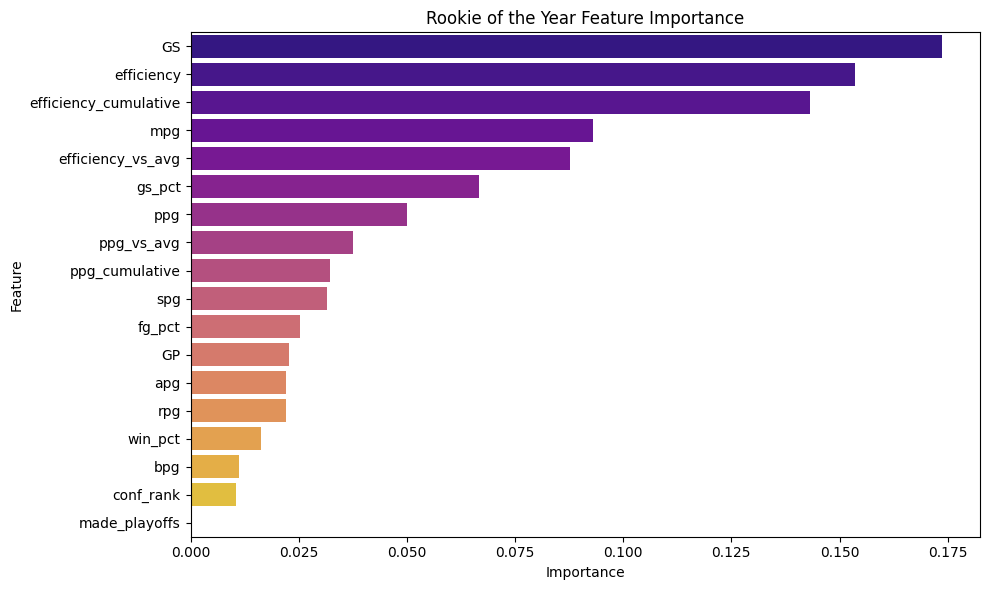


// Top 10 Most Important Features:
                  Feature  Importance
10                     GS    0.173775
7              efficiency    0.153529
17  efficiency_cumulative    0.143076
5                     mpg    0.093112
15      efficiency_vs_avg    0.087706
8                  gs_pct    0.066737
0                     ppg    0.050145
14             ppg_vs_avg    0.037449
16         ppg_cumulative    0.032327
3                     spg    0.031633


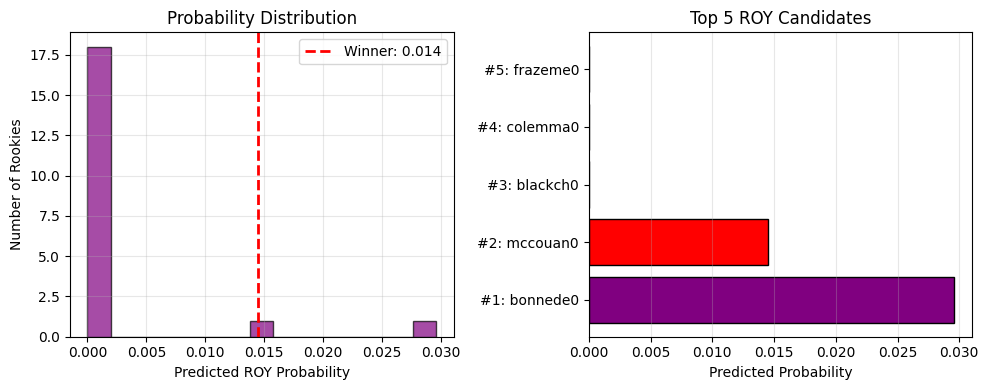


// Results saved to: data_models/predictions_roy.csv


In [ ]:
# ===============================================================
# ROOKIE OF THE YEAR — MODEL & EVALUATION
# ===============================================================

target = 'won_rookie_of_the_year'

# ===============================================================
# (1) Filter only rookies
# ===============================================================
train_data = pd.read_csv(TRAIN_DATA_DIR)
test_data = pd.read_csv(TEST_DATA_DIR)

train_rookies = train_data[train_data["is_rookie"] == 1]
test_rookies = test_data[test_data["is_rookie"] == 1]

print(f"Rookie training data: {train_rookies.shape}")
print(f"Rookie test data: {test_rookies.shape}")

# ===============================================================
# (2) Features for rookies
# ===============================================================
features_roy = [
    # current performance
    'ppg', 'rpg', 'apg', 'spg', 'bpg', 'mpg',
    'fg_pct', 'efficiency', 'gs_pct', 'GP', 'GS',
    'win_pct', 'made_playoffs', 'conf_rank',
    
    # comparative metrics
    'ppg_vs_avg', 'efficiency_vs_avg',
    
    # cumulative features
    'ppg_cumulative', 'efficiency_cumulative'
]

x_train = train_rookies[features_roy]
y_train = train_rookies[target]
x_test = test_rookies[features_roy]
y_test = test_rookies[target]

print(f"\nROY winners in training: {y_train.sum()}")
print(f"ROY winners in test: {y_test.sum()}")
print(f"Class balance: {y_train.sum()}/{len(y_train)} = {y_train.sum()/len(y_train)*100:.2f}%")

# ===============================================================
# (3) Train model
# ===============================================================
model_roy = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    class_weight='balanced'
)
model_roy.fit(x_train, y_train)

# ===============================================================
# (4) Predictions
# ===============================================================
test_rookies = test_rookies.copy()
test_rookies.loc[:, 'roy_proba'] = model_roy.predict_proba(x_test)[:, 1]
test_rookies.loc[:, 'roy_rank'] = test_rookies['roy_proba'].rank(ascending=False, method='first')

# ===============================================================
# (5) Evaluation
# ===============================================================
winner_rank = None
winner_proba = None

actual_winner_id_array = test_rookies[test_rookies[target] == 1]['playerID'].values
if len(actual_winner_id_array) > 0:
    actual_winner_id = actual_winner_id_array[0]
    winner_rank = test_rookies[test_rookies['playerID'] == actual_winner_id]['roy_rank'].values[0]
    winner_proba = test_rookies[test_rookies['playerID'] == actual_winner_id]['roy_proba'].values[0]
    
    print(f"\n// ROY Ranking Evaluation for year {target_year}:")
    print(f"Actual winner rank: {int(winner_rank)} out of {len(test_rookies)}")
    print(f"Actual winner probability: {winner_proba:.3f}")
    print(f"Top-1 prediction: {'✓ CORRECT' if winner_rank == 1 else '✗ INCORRECT'}")
    print(f"Top-3 prediction: {'✓ CORRECT' if winner_rank <= 3 else '✗ INCORRECT'}")
    print(f"Top-5 prediction: {'✓ CORRECT' if winner_rank <= 5 else '✗ INCORRECT'}")
    
    mrr = 1.0 / winner_rank
    print(f"Mean Reciprocal Rank: {mrr:.4f}")
else:
    print("\nNo ROY winner in test set")

# ===============================================================
# (6) Top ROY candidates
# ===============================================================
print("\n// Top 10 Rookie of the Year candidates:")
top_roy = test_rookies[[
    'playerID', 'tmID', 'ppg', 'rpg', 'apg', 'efficiency',
    'win_pct', 'made_playoffs',
    'roy_proba', 'roy_rank', 'won_rookie_of_the_year'
]].sort_values('roy_proba', ascending=False).head(10)
print(top_roy[['playerID', 'tmID', 'ppg', 'win_pct', 'roy_proba', 'roy_rank', 'won_rookie_of_the_year']])

# ===============================================================
# (7) ROY Interpretability Insights
# ===============================================================
print("Top 3 ROY Candidates and Key Factors:")
top_3_roy = test_rookies.nsmallest(3, 'roy_rank')
for i, (_, row) in enumerate(top_3_roy.iterrows(), 1):
    print(f"\n{i}. {row['playerID']} (Rank #{int(row['roy_rank'])}, Prob: {row['roy_proba']:.3f})")
    print(f"   - Rookie Stats: {row['ppg']:.1f} PPG, {row['rpg']:.1f} RPG, {row['apg']:.1f} APG")
    print(f"   - Efficiency: {row['efficiency']:.1f}")
    print(f"   - Team Success: {row['win_pct']:.1f} win %, Conference rank {row['conf_rank']}")
    print(f"   - Rookie Status: Confirmed rookie (0 years experience)")
    if row['playerID'] == actual_winner_id:
        print("   *** ACTUAL WINNER ***")

# ===============================================================
# (8) Feature Importance
# ===============================================================
importance = pd.DataFrame({
    'Feature': features_roy,
    'Importance': model_roy.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance, x='Importance', y='Feature', hue='Feature', palette='plasma', legend=False)
plt.title('Rookie of the Year Feature Importance')
plt.tight_layout()
plt.show()

print("\n// Top 10 Most Important Features:")
print(importance.head(10))

# ===============================================================
# (9) Additional Visualizations
# ===============================================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(test_rookies['roy_proba'], bins=15, color='purple', edgecolor='black', alpha=0.7)
if winner_proba is not None:
    plt.axvline(winner_proba, color='red', linestyle='--', linewidth=2, label=f'Winner: {winner_proba:.3f}')
    plt.legend()
plt.xlabel('Predicted ROY Probability')
plt.ylabel('Number of Rookies')
plt.title('Probability Distribution')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
top_5 = test_rookies.nsmallest(5, 'roy_rank')
colors = ['red' if pid == actual_winner_id else 'purple' for pid in top_5['playerID']]
plt.barh(range(len(top_5)), top_5['roy_proba'], color=colors, edgecolor='black')
plt.yticks(range(len(top_5)), [f"#{int(r)}: {pid[:8]}" for r, pid in zip(top_5['roy_rank'], top_5['playerID'])])
plt.xlabel('Predicted Probability')
plt.title('Top 5 ROY Candidates')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# ===============================================================
# (10) Save predictions
# ===============================================================
test_rookies.to_csv("data_models/predictions_roy.csv", index=False)
print("\n// Results saved to: data_models/predictions_roy.csv")


MIP eligible training data: (1017, 91)
MIP eligible test data: (125, 89)

MIP winners in training: 7
MIP winners in test: 1
Class balance: 7/1017 = 0.69%

// MIP Ranking Evaluation for year 10:
Actual winner rank: 3 out of 125
Actual winner probability: 0.413
Top-1 prediction: ✗ INCORRECT
Top-3 prediction: ✓ CORRECT
Top-5 prediction: ✓ CORRECT
Mean Reciprocal Rank: 0.3333

// Top 10 Most Improved Player candidates:
       playerID        ppg  ppg_improvement  efficiency_improvement  \
57   johnste01w   9.647059         5.473146                7.877238   
39   hardili01w  12.794118         6.377451                9.053922   
64   langhcr01w  12.000000         7.176471               11.058824   
37   grudasa01w  13.461538         7.235732               10.193548   
106  quinnno01w   8.352941         4.727941                7.818015   
73   lyttlsa01w  13.029412         4.807190                6.061002   
50   houstch01w  13.088235         4.239750                7.263815   
139  wrighta0

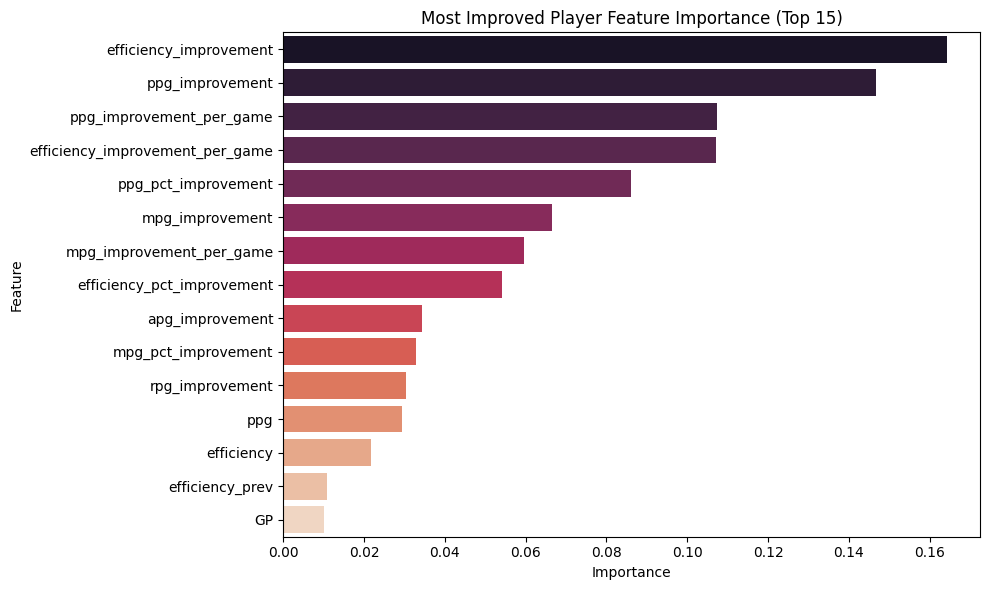


// Top 10 Most Important Features:
                            Feature  Importance
3            efficiency_improvement    0.164252
0                   ppg_improvement    0.146674
8          ppg_improvement_per_game    0.107352
9   efficiency_improvement_per_game    0.107210
5               ppg_pct_improvement    0.086121
4                   mpg_improvement    0.066644
10         mpg_improvement_per_game    0.059595
6        efficiency_pct_improvement    0.054064
2                   apg_improvement    0.034398
7               mpg_pct_improvement    0.032831


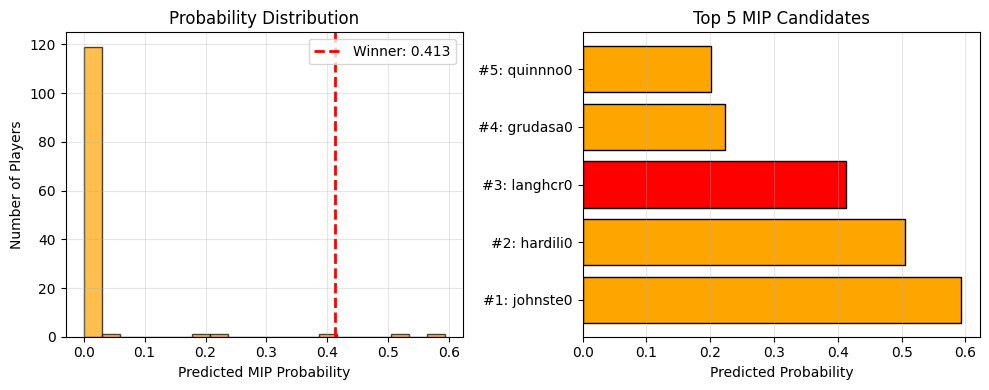

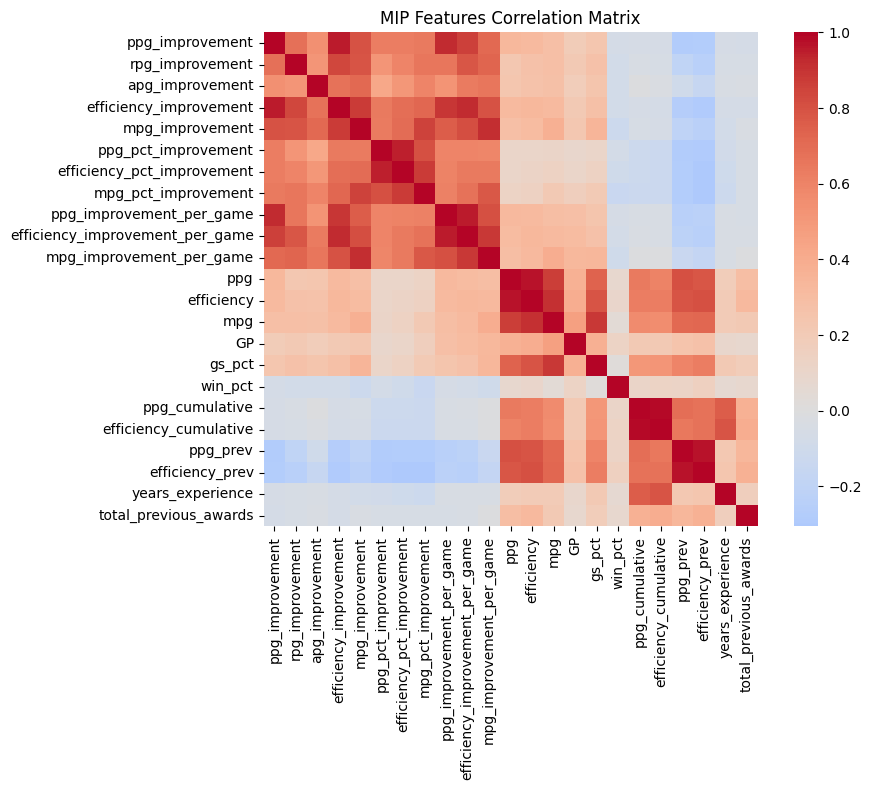


// Results saved to: data_models/predictions_mip.csv


In [ ]:
# ===============================================================
# MOST IMPROVED PLAYER — MODEL & EVALUATION
# ===============================================================

target = 'won_most_improved_player'

# ===============================================================
# (1) Filter to eligible players (not rookies, have previous year data)
# ===============================================================
train_data = pd.read_csv(TRAIN_DATA_DIR)
test_data = pd.read_csv(TEST_DATA_DIR)

train_eligible = train_data[
    (train_data["is_rookie"] == 0) &
    (train_data['ppg_prev'] > 0)  # has previous year data
].copy()

test_eligible = test_data[
    (test_data["is_rookie"] == 0) &
    (test_data['ppg_prev'] > 0)
].copy()

print(f"MIP eligible training data: {train_eligible.shape}")
print(f"MIP eligible test data: {test_eligible.shape}")

# ===============================================================
# (2) Features for Most Improved Player (REGULAR SEASON AWARD)
# ===============================================================
improvement_cols = ['ppg', 'rpg', 'apg', 'efficiency', 'mpg']

for col in improvement_cols:
    train_eligible[f'{col}_improvement'] = train_eligible[col] - train_eligible[f'{col}_prev']
    test_eligible[f'{col}_improvement'] = test_eligible[col] - test_eligible[f'{col}_prev']
    
    prev_safe = train_eligible[f'{col}_prev'].clip(lower=0.1)
    train_eligible[f'{col}_pct_improvement'] = (train_eligible[col] - train_eligible[f'{col}_prev']) / prev_safe
    
    prev_safe = test_eligible[f'{col}_prev'].clip(lower=0.1)
    test_eligible[f'{col}_pct_improvement'] = (test_eligible[col] - test_eligible[f'{col}_prev']) / prev_safe
    
    train_eligible[f'{col}_improvement_per_game'] = train_eligible[f'{col}_improvement'] / train_eligible['GP']
    test_eligible[f'{col}_improvement_per_game'] = test_eligible[f'{col}_improvement'] / test_eligible['GP']


features_mip = [
    # raw improvements
    'ppg_improvement', 'rpg_improvement', 'apg_improvement', 
    'efficiency_improvement', 'mpg_improvement',
    
    # percentage improvements
    'ppg_pct_improvement', 'efficiency_pct_improvement', 'mpg_pct_improvement',
    
    # per-game improvements
    'ppg_improvement_per_game', 'efficiency_improvement_per_game', 'mpg_improvement_per_game',
    
    # current year performance
    'ppg', 'efficiency', 'mpg', 'GP',
    
    # team context
    'gs_pct', 'win_pct',
    
    # cumulative features
    'ppg_cumulative', 'efficiency_cumulative',
    
    # previous baseline
    'ppg_prev', 'efficiency_prev',
    
    # experience
    'years_experience',
    
    # award history
    'total_previous_awards'
]

x_train = train_eligible[features_mip]
y_train = train_eligible[target]
x_test = test_eligible[features_mip]
y_test = test_eligible[target]

print(f"\nMIP winners in training: {y_train.sum()}")
print(f"MIP winners in test: {y_test.sum()}")
print(f"Class balance: {y_train.sum()}/{len(y_train)} = {y_train.sum()/len(y_train)*100:.2f}%")

# ===============================================================
# (3) Train model
# ===============================================================
model_mip = RandomForestClassifier(
    n_estimators=400,
    max_depth=8,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',
    max_features='sqrt'
)
model_mip.fit(x_train, y_train)

# ===============================================================
# (4) Predictions
# ===============================================================
test_eligible = test_eligible.copy()
test_eligible.loc[:, 'mip_proba'] = model_mip.predict_proba(x_test)[:, 1]
test_eligible.loc[:, 'mip_rank'] = test_eligible['mip_proba'].rank(ascending=False, method='first')

# ===============================================================
# (5) Evaluation
# ===============================================================
actual_winner_id_array = test_eligible[test_eligible[target] == 1]['playerID'].values
if len(actual_winner_id_array) > 0:
    actual_winner_id = actual_winner_id_array[0]
    winner_rank = test_eligible[test_eligible['playerID'] == actual_winner_id]['mip_rank'].values[0]
    winner_proba = test_eligible[test_eligible['playerID'] == actual_winner_id]['mip_proba'].values[0]
    
    print(f"\n// MIP Ranking Evaluation for year {target_year}:")
    print(f"Actual winner rank: {int(winner_rank)} out of {len(test_eligible)}")
    print(f"Actual winner probability: {winner_proba:.3f}")
    print(f"Top-1 prediction: {'✓ CORRECT' if winner_rank == 1 else '✗ INCORRECT'}")
    print(f"Top-3 prediction: {'✓ CORRECT' if winner_rank <= 3 else '✗ INCORRECT'}")
    print(f"Top-5 prediction: {'✓ CORRECT' if winner_rank <= 5 else '✗ INCORRECT'}")
    
    mrr = 1.0 / winner_rank
    print(f"Mean Reciprocal Rank: {mrr:.4f}")
else:
    print("\nNo MIP winner in test set")

# ===============================================================
# (6) Top MIP candidates
# ===============================================================
print("\n// Top 10 Most Improved Player candidates:")
top_mip = test_eligible[[
    'playerID', 'tmID', 'ppg', 'ppg_prev', 'ppg_improvement',
    'efficiency', 'efficiency_improvement', 'win_pct',
    'mip_proba', 'mip_rank', 'won_most_improved_player'
]].sort_values('mip_proba', ascending=False).head(10)
print(top_mip[['playerID', 'ppg', 'ppg_improvement', 'efficiency_improvement', 'mip_proba', 'mip_rank', 'won_most_improved_player']])

# ===============================================================
# (7) MIP Interpretability Insights
# ===============================================================
print("Top 3 MIP Candidates and Key Factors:")
top_3_mip = test_eligible.nsmallest(3, 'mip_rank')
for i, (_, row) in enumerate(top_3_mip.iterrows(), 1):
    print(f"\n{i}. {row['playerID']} (Rank #{int(row['mip_rank'])}, Prob: {row['mip_proba']:.3f})")
    print(f"   - Current Season: {row['ppg']:.1f} PPG, {row['efficiency']:.1f} EFF")
    print(f"   - Improvement: PPG +{row['ppg_improvement']:.1f}, EFF +{row['efficiency_improvement']:.1f}")
    print(f"   - Previous Performance: {row['ppg_prev']:.1f} PPG, {row['efficiency_prev']:.1f} EFF")
    print(f"   - Experience: {row['years_experience']} years, {row['total_previous_awards']} prior awards")
    if row['playerID'] == actual_winner_id:
        print("   *** ACTUAL WINNER ***")

# ===============================================================
# (8) Feature Importance
# ===============================================================
importance = pd.DataFrame({
    'Feature': features_mip,
    'Importance': model_mip.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance.head(15), x='Importance', y='Feature', hue='Feature', palette='rocket', legend=False)
plt.title('Most Improved Player Feature Importance (Top 15)')
plt.tight_layout()
plt.show()

print("\n// Top 10 Most Important Features:")
print(importance.head(10))

# ===============================================================
# (9) Additional Visualizations
# ===============================================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(test_eligible['mip_proba'], bins=20, color='orange', edgecolor='black', alpha=0.7)
if winner_proba is not None:
    plt.axvline(winner_proba, color='red', linestyle='--', linewidth=2, label=f'Winner: {winner_proba:.3f}')
    plt.legend()
plt.xlabel('Predicted MIP Probability')
plt.ylabel('Number of Players')
plt.title('Probability Distribution')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
top_5 = test_eligible.nsmallest(5, 'mip_rank')
colors = ['red' if pid == actual_winner_id else 'orange' for pid in top_5['playerID']]
plt.barh(range(len(top_5)), top_5['mip_proba'], color=colors, edgecolor='black')
plt.yticks(range(len(top_5)), [f"#{int(r)}: {pid[:8]}" for r, pid in zip(top_5['mip_rank'], top_5['playerID'])])
plt.xlabel('Predicted Probability')
plt.title('Top 5 MIP Candidates')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# correlation matrix for MIP features
plt.figure(figsize=(10, 8))
corr_matrix = train_eligible[features_mip].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, square=True)
plt.title('MIP Features Correlation Matrix')
plt.tight_layout()
plt.show()

# ===============================================================
# (10)  Save predictions
# ===============================================================
test_eligible.to_csv("data_models/predictions_mip.csv", index=False)
print("\n// Results saved to: data_models/predictions_mip.csv")


Finals MVP eligible training data: (102, 91)
Finals MVP eligible test data: (145, 89)

Finals MVP winners in training: 9
Finals MVP winners in test: 1
Class balance: 9/102 = 8.82%

// Finals MVP Ranking Evaluation for year 10:
Actual winner rank: 7 out of 145
Actual winner probability: 0.107
Top-1 prediction: ✗ INCORRECT
Top-3 prediction: ✗ INCORRECT
Top-5 prediction: ✗ INCORRECT
Mean Reciprocal Rank: 0.1429

// Top 10 WNBA Finals MVP candidates:
       playerID tmID        ppg       apg  efficiency  playoff_wins  \
118  suttota01w  IND   9.851852  0.851852   16.777778             6   
101  pondeca01w  PHO  19.058824  5.029412   27.058824             7   
45   hoffmeb01w  IND   9.941176  1.529412   16.941176             6   
121  taylope01w  PHO  10.928571  2.285714   14.857143             7   
27   douglka01w  IND  17.645161  2.741935   23.870968             6   
94   nolande01w  DET  16.939394  3.515152   24.151515             3   
120  tauradi01w  PHO  20.354839  3.516129   29.51612

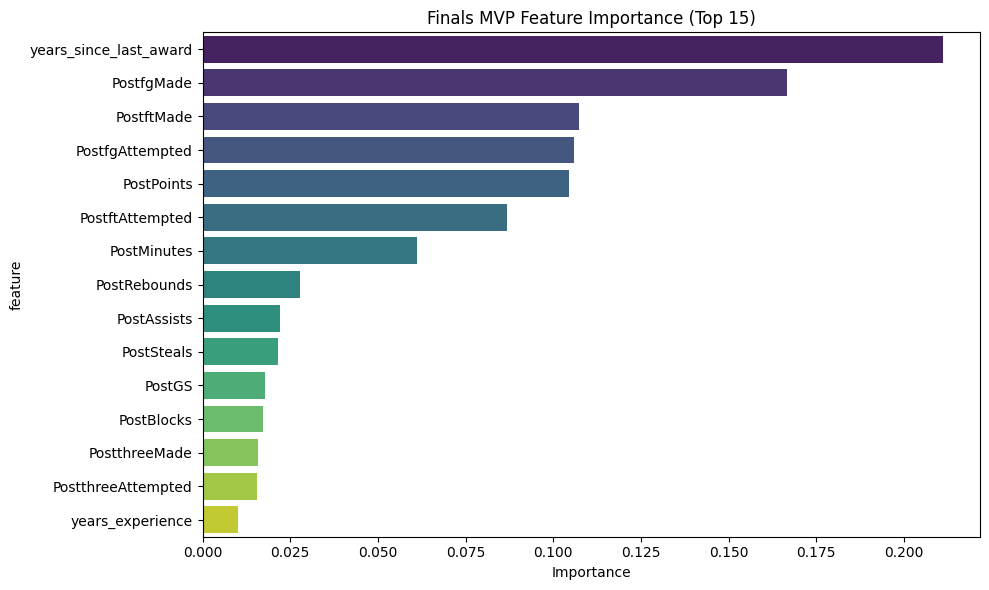

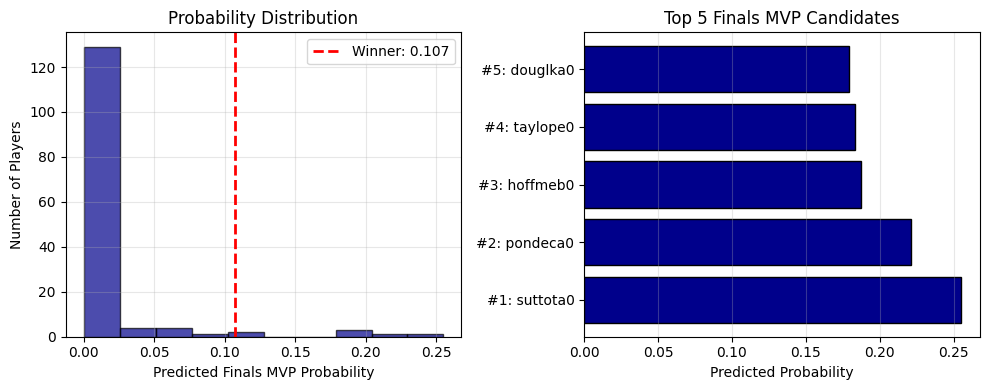

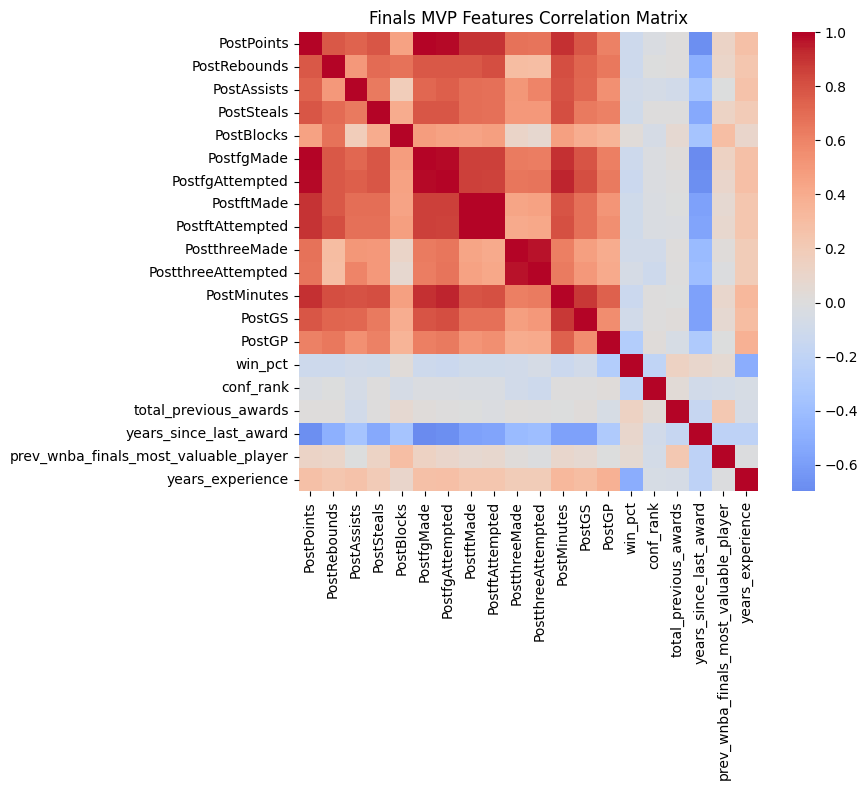


// Results saved to: data_models/predictions_fmvp.csv


In [ ]:
# ===============================================================
# WNBA FINALS MVP PREDICTION
# ===============================================================

target = 'won_wnba_finals_most_valuable_player'

# ===============================================================
# (1) Eligibility Filtering
# ===============================================================
train_data = pd.read_csv(TRAIN_DATA_DIR)
test_data = pd.read_csv(TEST_DATA_DIR)

train_finals = train_data[
    (train_data['won_championship'] == 1)
].copy()

test_finals = test_data[
    (test_data['made_playoffs'] == 1)
].copy()

print(f"Finals MVP eligible training data: {train_finals.shape}")
print(f"Finals MVP eligible test data: {test_finals.shape}")

# ===============================================================
# (2) Feature Selection
# ===============================================================
# Finals MVP: best player on championship team
features_fmvp = [
    # playoff scoring and production (PRIMARY - award based on playoff performance)
    'PostPoints', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks',
    
    # playoff efficiency and shooting
    'PostfgMade', 'PostfgAttempted', 'PostftMade', 'PostftAttempted', 
    'PostthreeMade', 'PostthreeAttempted', 'PostMinutes',
    
    # playoff usage and role
    'PostGS', 'PostGP',
    
    # playoff impact per game (normalized for different playoff runs)
    # 'post_points_per_game', 'post_rebounds_per_game', 'post_assists_per_game',  # Would need to calculate these
    
    # team success in playoffs (removed playoff_wins - temporal violation)
    'win_pct', 'conf_rank',
    
    # award history (experience matters for Finals MVP)
    'total_previous_awards', 'years_since_last_award',
    'prev_wnba_finals_most_valuable_player',
    
    # experience
    'years_experience'
]

x_train = train_finals[features_fmvp]
y_train = train_finals[target]
x_test = test_finals[features_fmvp]
y_test = test_finals[target]

print(f"\nFinals MVP winners in training: {y_train.sum()}")
print(f"Finals MVP winners in test: {y_test.sum()}")
print(f"Class balance: {y_train.sum()}/{len(y_train)} = {y_train.sum()/len(y_train)*100:.2f}%")

# ===============================================================
# (3) Train model
# ===============================================================
model_fmvp = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_split=3,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model_fmvp.fit(x_train, y_train)

# ===============================================================
# (4) Predictions
# ===============================================================
test_finals = test_finals.copy()
test_finals.loc[:, 'fmvp_proba'] = model_fmvp.predict_proba(x_test)[:, 1]
test_finals.loc[:, 'fmvp_rank'] = test_finals['fmvp_proba'].rank(ascending=False, method='first')

# ===============================================================
# (5) Evaluation
# ===============================================================
actual_winner_id_array = test_finals[test_finals[target] == 1]['playerID'].values
if len(actual_winner_id_array) > 0:
    actual_winner_id = actual_winner_id_array[0]
    winner_rank = test_finals[test_finals['playerID'] == actual_winner_id]['fmvp_rank'].values[0]
    winner_proba = test_finals[test_finals['playerID'] == actual_winner_id]['fmvp_proba'].values[0]
    
    print(f"\n// Finals MVP Ranking Evaluation for year {target_year}:")
    print(f"Actual winner rank: {int(winner_rank)} out of {len(test_finals)}")
    print(f"Actual winner probability: {winner_proba:.3f}")
    print(f"Top-1 prediction: {'✓ CORRECT' if winner_rank == 1 else '✗ INCORRECT'}")
    print(f"Top-3 prediction: {'✓ CORRECT' if winner_rank <= 3 else '✗ INCORRECT'}")
    print(f"Top-5 prediction: {'✓ CORRECT' if winner_rank <= 5 else '✗ INCORRECT'}")
    
    mrr = 1.0 / winner_rank
    print(f"Mean Reciprocal Rank: {mrr:.4f}")
else:
    print("\nNo Finals MVP winner in test set")

# ===============================================================
# (6) Top WNBA Finals MVP candidates
# ===============================================================
print("\n// Top 10 WNBA Finals MVP candidates:")
top_fmvp = test_finals[[
    'playerID', 'tmID', 'ppg', 'rpg', 'apg', 'efficiency',
    'mpg', 'playoff_wins', 'win_pct',
    'fmvp_proba', 'fmvp_rank', target
]].sort_values('fmvp_proba', ascending=False).head(10)
print(top_fmvp[['playerID', 'tmID', 'ppg', 'apg', 'efficiency', 'playoff_wins', 'fmvp_proba', 'fmvp_rank', target]])

# ===============================================================
# (7) Finals MVP Interpretability Insights
# ===============================================================
print("Top 3 Finals MVP Candidates and Key Factors:")
top_3_fmvp = test_finals.nsmallest(3, 'fmvp_rank')
for i, (_, row) in enumerate(top_3_fmvp.iterrows(), 1):
    print(f"\n{i}. {row['playerID']} (Rank #{int(row['fmvp_rank'])}, Prob: {row['fmvp_proba']:.3f})")
    print(f"   - Playoff Performance: {row['PostPoints']:.1f} PPG, {row['PostRebounds']:.1f} RPG, {row['PostAssists']:.1f} APG")
    print(f"   - Regular Season: {row['ppg']:.1f} PPG, {row['efficiency']:.1f} EFF")
    print(f"   - Team Success: {row['win_pct']:.1f} win %, {row['playoff_wins']} playoff wins, Championship: {row['won_championship']}")
    print(f"   - Experience: {row['years_experience']} years, {row['total_previous_awards']} prior awards")
    if row['playerID'] == actual_winner_id:
        print("   *** ACTUAL WINNER ***")

# ===============================================================
# (8) Feature Importance
# ===============================================================
importance = pd.DataFrame({
    'feature': features_fmvp,
    'importance': model_fmvp.feature_importances_
}).sort_values('importance', ascending=False)

print("\n// Top 10 Most Important Features:")
print(importance.head(10))

# ===============================================================
# (9) Visualizations
# ===============================================================
plt.figure(figsize=(10, 6))
sns.barplot(data=importance.head(15), x='importance', y='feature', hue='feature', palette='viridis', legend=False)
plt.title('Finals MVP Feature Importance (Top 15)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(test_finals['fmvp_proba'], bins=10, color='darkblue', edgecolor='black', alpha=0.7)
if len(test_finals[test_finals[target] == 1]) > 0:
    winner_prob = test_finals[test_finals[target] == 1]['fmvp_proba'].values[0]
    plt.axvline(winner_prob, color='red', linestyle='--', linewidth=2, label=f'Winner: {winner_prob:.3f}')
    plt.legend()
plt.xlabel('Predicted Finals MVP Probability')
plt.ylabel('Number of Players')
plt.title('Probability Distribution')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
top_5 = test_finals.nsmallest(5, 'fmvp_rank')
actual_winner_ids = test_finals[test_finals[target] == 1]['playerID'].values
colors = ['red' if pid in actual_winner_ids else 'darkblue' for pid in top_5['playerID']]
plt.barh(range(len(top_5)), top_5['fmvp_proba'], color=colors, edgecolor='black')
plt.yticks(range(len(top_5)), [f"#{int(r)}: {pid[:8]}" for r, pid in zip(top_5['fmvp_rank'], top_5['playerID'])])
plt.xlabel('Predicted Probability')
plt.title('Top 5 Finals MVP Candidates')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# correlation matrix for Finals MVP features
plt.figure(figsize=(10, 8))
corr_matrix = train_finals[features_fmvp].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, square=True)
plt.title('Finals MVP Features Correlation Matrix')
plt.tight_layout()
plt.show()

# ===============================================================
# (10) Save predictions
# ===============================================================
test_finals.to_csv('data_models/predictions_fmvp.csv', index=False)
print("\n// Results saved to: data_models/predictions_fmvp.csv")


In [ ]:
# ===============================================================
# SUMMARY OF ALL AWARD PREDICTIONS
# ===============================================================

print("="*70)
print(f"FINAL AWARD PREDICTIONS FOR YEAR {target_year}")
print("="*70)

mvp_pred = pd.read_csv("data_models/predictions_mvp.csv")
dpoy_pred = pd.read_csv("data_models/predictions_dpoy.csv")
roy_pred = pd.read_csv("data_models/predictions_roy.csv")
mip_pred = pd.read_csv("data_models/predictions_mip.csv")
asg_pred = pd.read_csv("data_models/predictions_asg.csv")
fmvp_pred = pd.read_csv("data_models/predictions_fmvp.csv")

mvp_winner = mvp_pred.nlargest(1, 'mvp_proba')
dpoy_winner = dpoy_pred.nlargest(1, 'dpoy_proba')
roy_winner = roy_pred.nlargest(1, 'roy_proba')
mip_winner = mip_pred.nlargest(1, 'mip_proba')
asg_winner = asg_pred.nlargest(1, 'asg_proba')
fmvp_winner = fmvp_pred.nlargest(1, 'fmvp_proba')

mvp_actual = mvp_pred[mvp_pred['won_most_valuable_player'] == 1]
dpoy_actual = dpoy_pred[dpoy_pred['won_defensive_player_of_the_year'] == 1]
roy_actual = roy_pred[roy_pred['won_rookie_of_the_year'] == 1]
mip_actual = mip_pred[mip_pred['won_most_improved_player'] == 1]
asg_actual = asg_pred[asg_pred['won_all-star_game_most_valuable_player'] == 1]
fmvp_actual = fmvp_pred[fmvp_pred['won_wnba_finals_most_valuable_player'] == 1]

print("\n// MOST VALUABLE PLAYER (Year 10):")
print(f"  Predicted: {mvp_winner['playerID'].values[0]}")
print(f"  Team: {mvp_winner['tmID'].values[0]}")
print(f"  PPG: {mvp_winner['ppg'].values[0]:.1f}")
print(f"  RPG: {mvp_winner['rpg'].values[0]:.1f}")
print(f"  APG: {mvp_winner['apg'].values[0]:.1f}")
print(f"  Confidence: {mvp_winner['mvp_proba'].values[0]:.1%}")
if len(mvp_actual) > 0:
    is_correct = mvp_winner['playerID'].values[0] == mvp_actual['playerID'].values[0]
    actual_rank = int(mvp_actual['mvp_rank'].values[0])
    print(f"  Prediction: {'✓ CORRECT' if is_correct else f'✗ INCORRECT (actual winner ranked #{actual_rank})'}")
    print(f"  Actual winner: {mvp_actual['playerID'].values[0]}")

print("\n// DEFENSIVE PLAYER OF THE YEAR:")
print(f"  Predicted: {dpoy_winner['playerID'].values[0]}")
print(f"  Team: {dpoy_winner['tmID'].values[0]}")
print(f"  SPG: {dpoy_winner['spg'].values[0]:.1f}")
print(f"  BPG: {dpoy_winner['bpg'].values[0]:.1f}")
print(f"  RPG: {dpoy_winner['rpg'].values[0]:.1f}")
print(f"  Confidence: {dpoy_winner['dpoy_proba'].values[0]:.1%}")
if len(dpoy_actual) > 0:
    is_correct = dpoy_winner['playerID'].values[0] == dpoy_actual['playerID'].values[0]
    actual_rank = int(dpoy_actual['dpoy_rank'].values[0])
    print(f"  Prediction: {'✓ CORRECT' if is_correct else f'✗ INCORRECT (actual winner ranked #{actual_rank})'}")
    print(f"  Actual winner: {dpoy_actual['playerID'].values[0]}")

print("\n// ROOKIE OF THE YEAR:")
print(f"  Predicted: {roy_winner['playerID'].values[0]}")
print(f"  Team: {roy_winner['tmID'].values[0]}")
print(f"  PPG: {roy_winner['ppg'].values[0]:.1f}")
print(f"  RPG: {roy_winner['rpg'].values[0]:.1f}")
print(f"  APG: {roy_winner['apg'].values[0]:.1f}")
print(f"  Confidence: {roy_winner['roy_proba'].values[0]:.1%}")
if len(roy_actual) > 0:
    is_correct = roy_winner['playerID'].values[0] == roy_actual['playerID'].values[0]
    actual_rank = int(roy_actual['roy_rank'].values[0])
    print(f"  Prediction: {'✓ CORRECT' if is_correct else f'✗ INCORRECT (actual winner ranked #{actual_rank})'}")
    print(f"  Actual winner: {roy_actual['playerID'].values[0]}")

print("\n// MOST IMPROVED PLAYER:")
print(f"  Predicted: {mip_winner['playerID'].values[0]}")
print(f"  Team: {mip_winner['tmID'].values[0]}")
print(f"  PPG: {mip_winner['ppg'].values[0]:.1f} (Improvement: {mip_winner['ppg_improvement'].values[0]:+.1f})")
print(f"  Efficiency: {mip_winner['efficiency'].values[0]:.1f} (Improvement: {mip_winner['efficiency_improvement'].values[0]:+.1f})")
print(f"  Confidence: {mip_winner['mip_proba'].values[0]:.1%}")
if len(mip_actual) > 0:
    is_correct = mip_winner['playerID'].values[0] == mip_actual['playerID'].values[0]
    actual_rank = int(mip_actual['mip_rank'].values[0])
    print(f"  Prediction: {'✓ CORRECT' if is_correct else f'✗ INCORRECT (actual winner ranked #{actual_rank})'}")
    print(f"  Actual winner: {mip_actual['playerID'].values[0]}")

print("\n// WNBA FINALS MVP:")
print(f"  Predicted: {fmvp_winner['playerID'].values[0]}")
print(f"  Team: {fmvp_winner['tmID'].values[0]}")
print(f"  PPG: {fmvp_winner['ppg'].values[0]:.1f}")
print(f"  RPG: {fmvp_winner['rpg'].values[0]:.1f}")
print(f"  APG: {fmvp_winner['apg'].values[0]:.1f}")
print(f"  Playoff Wins: {int(fmvp_winner['playoff_wins'].values[0])}")
print(f"  Confidence: {fmvp_winner['fmvp_proba'].values[0]:.1%}")
if len(fmvp_actual) > 0:
    is_correct = fmvp_winner['playerID'].values[0] == fmvp_actual['playerID'].values[0]
    actual_rank = int(fmvp_actual['fmvp_rank'].values[0])
    print(f"  Prediction: {'✓ CORRECT' if is_correct else f'✗ INCORRECT (actual winner ranked #{actual_rank})'}")
    print(f"  Actual winner: {fmvp_actual['playerID'].values[0]}")

correct = 0
total = 0
if len(mvp_actual) > 0:
    correct += (mvp_winner['playerID'].values[0] == mvp_actual['playerID'].values[0])
    total += 1
if len(dpoy_actual) > 0:
    correct += (dpoy_winner['playerID'].values[0] == dpoy_actual['playerID'].values[0])
    total += 1
if len(roy_actual) > 0:
    correct += (roy_winner['playerID'].values[0] == roy_actual['playerID'].values[0])
    total += 1
if len(mip_actual) > 0:
    correct += (mip_winner['playerID'].values[0] == mip_actual['playerID'].values[0])
    total += 1
if len(asg_actual) > 0:
    correct += (asg_winner['playerID'].values[0] == asg_actual['playerID'].values[0])
    total += 1
if len(fmvp_actual) > 0:
    correct += (fmvp_winner['playerID'].values[0] == fmvp_actual['playerID'].values[0])
    total += 1

print("\n" + "="*70)
print(f"Overall Top-1 Accuracy: {correct}/{total} = {correct/total*100:.1f}%" if total > 0 else "No winners in test set")
print("="*70)
print("All predictions complete!")

# ===============================================================
# FINAL INSIGHT: Awards and Team Success
# ===============================================================
print("\n" + "="*70)
print("KEY INSIGHTS FROM THE BASKETBALL CONTEXT:")
print("="*70)

if len(mvp_actual) > 0:
    mvp_team_wins = mvp_actual['win_pct'].values[0]
    mvp_playoffs = mvp_actual['made_playoffs'].values[0]
    print(f"\n// MVP Winner's Team: {mvp_team_wins:.1%} win rate, {'made playoffs' if mvp_playoffs else 'missed playoffs'}")

if len(dpoy_actual) > 0:
    dpoy_team_wins = dpoy_actual['win_pct'].values[0]
    dpoy_playoffs = dpoy_actual['made_playoffs'].values[0]
    print(f"// DPOY Winner's Team: {dpoy_team_wins:.1%} win rate, {'made playoffs' if dpoy_playoffs else 'missed playoffs'}")

if len(roy_actual) > 0:
    roy_team_wins = roy_actual['win_pct'].values[0]
    roy_playoffs = roy_actual['made_playoffs'].values[0]
    print(f"// ROY Winner's Team: {roy_team_wins:.1%} win rate, {'made playoffs' if roy_playoffs else 'missed playoffs'}")

if len(mip_actual) > 0:
    mip_team_wins = mip_actual['win_pct'].values[0]
    mip_improvement = mip_actual['ppg_improvement'].values[0]
    print(f"// MIP Winner's Team: {mip_team_wins:.1%} win rate, PPG improvement: {mip_improvement:+.1f}")

if len(fmvp_actual) > 0:
    fmvp_team_wins = fmvp_actual['win_pct'].values[0]
    fmvp_playoff_wins = int(fmvp_actual['playoff_wins'].values[0])
    print(f"// Finals MVP Winner's Team: {fmvp_team_wins:.1%} win rate, Playoff wins: {fmvp_playoff_wins}")

print("\n Teams with more wins qualify for playoffs.")
print("   Award winners are often from successful teams that make the playoffs.")
print("   Finals MVP always comes from the championship team.")
print("="*70)

# ===============================================================
# COMPREHENSIVE MODEL EVALUATION
# ===============================================================
print("\n" + "="*70)
print("COMPREHENSIVE MODEL EVALUATION METRICS:")
print("="*70)

all_predictions = []
all_actuals = []
all_models = []

# MVP metrics
if len(mvp_actual) > 0:
    mvp_predicted_rank = int(mvp_actual['mvp_rank'].values[0])
    all_predictions.append(mvp_predicted_rank)
    all_actuals.append(1)
    all_models.append('MVP')
    
# DPOY metrics  
if len(dpoy_actual) > 0:
    dpoy_predicted_rank = int(dpoy_actual['dpoy_rank'].values[0])
    all_predictions.append(dpoy_predicted_rank)
    all_actuals.append(1)
    all_models.append('DPOY')
    
# ROY metrics
if len(roy_actual) > 0:
    roy_predicted_rank = int(roy_actual['roy_rank'].values[0])
    all_predictions.append(roy_predicted_rank)
    all_actuals.append(1)
    all_models.append('ROY')

# MIP metrics
if len(mip_actual) > 0:
    mip_predicted_rank = int(mip_actual['mip_rank'].values[0])
    all_predictions.append(mip_predicted_rank)
    all_actuals.append(1)
    all_models.append('MIP')

# Finals MVP metrics
if len(fmvp_actual) > 0:
    fmvp_predicted_rank = int(fmvp_actual['fmvp_rank'].values[0])
    all_predictions.append(fmvp_predicted_rank)
    all_actuals.append(1)
    all_models.append('FMVP')

# Calculate aggregate metrics
if len(all_predictions) > 0:
    print("\n// Ranking Performance Metrics:")
    print(f"  Average Winner Rank: {np.mean(all_predictions):.2f}")
    print(f"  Median Winner Rank: {np.median(all_predictions):.1f}")
    print(f"  Best Rank: {np.min(all_predictions)}")
    print(f"  Worst Rank: {np.max(all_predictions)}")
    print(f"  Average MRR: {np.mean([1.0/r for r in all_predictions]):.4f}")
    
    print("\n// Success Rate by Top-K:")
    for k in [1, 3, 5, 10]:
        success_rate = np.mean([r <= k for r in all_predictions]) * 100
        print(f"  Top-{k:2d}: {success_rate:.1f}% ({int(success_rate * len(all_predictions) / 100)}/{len(all_predictions)} awards)")
    
    print("\n// Per-Award Performance:")
    for model, pred_rank in zip(all_models, all_predictions):
        mrr = 1.0 / pred_rank
        status = "✓" if pred_rank == 1 else "✗"
        print(f"  {model:4s}: Rank #{pred_rank:2d} | MRR={mrr:.4f} | {status}")

print("\n" + "="*70)


FINAL AWARD PREDICTIONS FOR YEAR 10

// MOST VALUABLE PLAYER (Year 10):
  Predicted: tauradi01w
  Team: PHO
  PPG: 20.4
  RPG: 5.7
  APG: 3.5
  Confidence: 23.0%
  Prediction: ✓ CORRECT
  Actual winner: tauradi01w

// DEFENSIVE PLAYER OF THE YEAR:
  Predicted: catchta01w
  Team: IND
  SPG: 2.9
  BPG: 0.5
  RPG: 7.2
  Confidence: 7.0%
  Prediction: ✓ CORRECT
  Actual winner: catchta01w

// ROOKIE OF THE YEAR:
  Predicted: bonnede01w
  Team: PHO
  PPG: 11.2
  RPG: 5.8
  APG: 0.4
  Confidence: 3.0%
  Prediction: ✗ INCORRECT (actual winner ranked #2)
  Actual winner: mccouan01w

// MOST IMPROVED PLAYER:
  Predicted: johnste01w
  Team: PHO
  PPG: 9.6 (Improvement: +5.5)
  Efficiency: 16.5 (Improvement: +7.9)
  Confidence: 59.3%
  Prediction: ✗ INCORRECT (actual winner ranked #3)
  Actual winner: langhcr01w

// WNBA FINALS MVP:
  Predicted: suttota01w
  Team: IND
  PPG: 9.9
  RPG: 5.9
  APG: 0.9
  Playoff Wins: 6
  Confidence: 25.5%
  Prediction: ✗ INCORRECT (actual winner ranked #7)
  Actua